In [ ]:
from google.colab import drive
from datetime import datetime
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, fbeta_score, classification_report
from sklearn.metrics import make_scorer 
import matplotlib.pyplot as plt
import gensim.downloader as api
import nltk
from nltk.tokenize import word_tokenize
from nltk import pos_tag
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

drive.mount('/content/gdrive')
dir_name = "/content/gdrive/MyDrive/Thesis/"

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


Mounted at /content/gdrive


In [ ]:
def get_raw_data(dir_name, file_name):
    #  load data
    data = pd.read_csv('{}{}.csv'.format(dir_name,file_name), encoding = 'latin-1', usecols=['medical_abstract', 'condition_label'])
    data = data.rename(columns={'medical_abstract': 'text', 'condition_label': 'label'})
    le = LabelEncoder()
    data['label'] = le.fit_transform( data['label'])
    return data

raw_train_data = get_raw_data(dir_name + 'datasets/Medical_Abstracts/', 'train')
raw_train_data

,label,text
0,4,Tissue changes around loose prostheses. A cani...
1,0,Neuropeptide Y and neuron-specific enolase lev...
2,1,"Sexually transmitted diseases of the colon, re..."
3,0,Lipolytic factors associated with murine and h...
4,2,Does carotid restenosis predict an increased r...
...,...,...
11545,0,Epirubicin at two dose levels with prednisolon...
11546,0,Four and a half year follow up of women with d...
11547,4,Safety of the transbronchial biopsy in outpati...
11548,2,Interictal spikes and hippocampal somatostatin...


In [ ]:
raw_train_data['text'].is_unique

False

In [ ]:
raw_train_data.drop_duplicates(subset=['text'], inplace=True)
raw_train_data['text'].is_unique

True

In [ ]:
raw_train_data

,label,text
0,4,Tissue changes around loose prostheses. A cani...
1,0,Neuropeptide Y and neuron-specific enolase lev...
2,1,"Sexually transmitted diseases of the colon, re..."
3,0,Lipolytic factors associated with murine and h...
4,2,Does carotid restenosis predict an increased r...
...,...,...
11539,2,Familial eating epilepsy. Eating-related seizu...
11543,3,Deep venous thrombosis in intravenous cocaine ...
11546,0,Four and a half year follow up of women with d...
11547,4,Safety of the transbronchial biopsy in outpati...


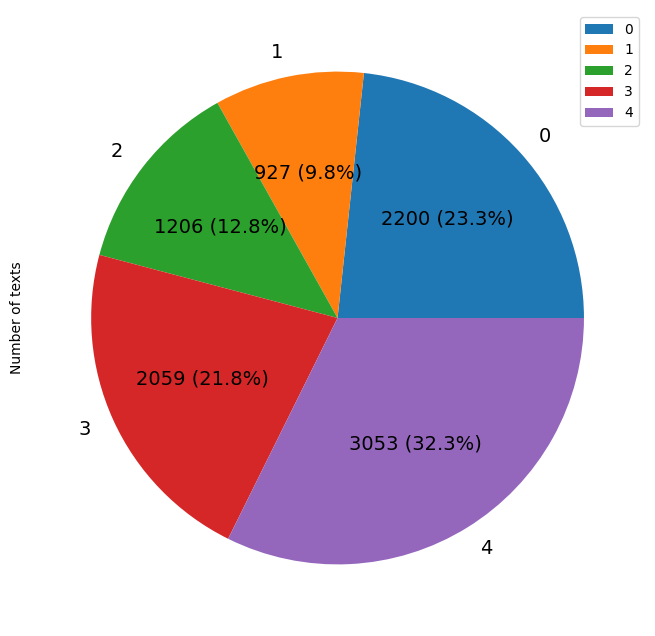

In [ ]:
def get_dataset_statistics(data):
    dataset_statistics = {'Number of texts': [data['label'].value_counts()[0], data['label'].value_counts()[1], data['label'].value_counts()[2], data['label'].value_counts()[3], data['label'].value_counts()[4]]}
    df = pd.DataFrame(dataset_statistics, index=['0', '1', '2', '3', '4'])
    df.plot(kind='pie', y='Number of texts', figsize=(8, 8), fontsize=14,
            autopct=lambda v: '{:.0f} ({:.1f}%)'.format(v / 100 * data['label'].count(), v))
    
# Raw data statistics
get_dataset_statistics(raw_train_data)

In [ ]:
raw_test_data = get_raw_data(dir_name + 'datasets/Medical_Abstracts/', 'test')
raw_test_data

,label,text
0,2,Obstructive sleep apnea following topical orop...
1,4,Neutrophil function and pyogenic infections in...
2,4,A phase II study of combined methotrexate and ...
3,0,Flow cytometric DNA analysis of parathyroid tu...
4,3,Paraneoplastic vasculitic neuropathy: a treata...
...,...,...
2883,3,Management of aortobronchial fistula with graf...
2884,4,Tuberculous psoas muscle abscess following che...
2885,3,Clinical evaluation of high-frequency (ultraso...
2886,0,Antitumor activity of liposome-encapsulated do...


In [ ]:
raw_test_data['text'].is_unique

False

In [ ]:
raw_test_data.drop_duplicates(subset=['text'], inplace=True)
raw_test_data['text'].is_unique

True

In [ ]:
raw_test_data['label'].value_counts()

4    912
0    616
3    589
2    366
1    287
Name: label, dtype: int64

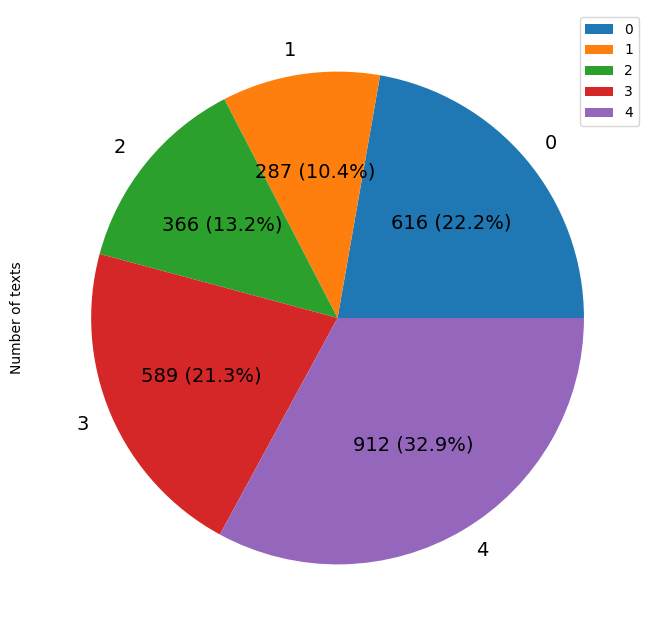

In [ ]:
get_dataset_statistics(raw_test_data)

# Text Preprocessing 

In [ ]:
import requests
stopwords_list = requests.get("https://github.com/stopwords-iso/stopwords-en/blob/master/stopwords-en.txt").content
stopwords = set(stopwords_list.decode().splitlines())

In [ ]:
import string
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
sklearn_stopwords = ENGLISH_STOP_WORDS

stop_words = set(stopwords.words('english'))
stop_words.update(sklearn_stopwords)

def text_preprocessing(raw_text):
  text_words = raw_text.translate(str.maketrans('', '', string.punctuation))
  msg_tokens = word_tokenize(text_words.lower())
  filtered_text = [token for token in msg_tokens if not token in stop_words]
  return " ".join(filtered_text)

In [ ]:
train_data = raw_train_data[['text', 'label']].copy()

train_data['text'] = train_data['text'].apply(text_preprocessing)

train_data.drop_duplicates(inplace=True)

train_data

,text,label
0,tissue changes loose prostheses canine model i...,4
1,neuropeptide neuronspecific enolase levels ben...,0
2,sexually transmitted diseases colon rectum anu...,1
3,lipolytic factors associated murine human canc...,0
4,carotid restenosis predict increased risk late...,2
...,...,...
11539,familial eating epilepsy eatingrelated seizure...,2
11543,deep venous thrombosis intravenous cocaine abu...,3
11546,half year follow women dyskaryotic cervical sm...,0
11547,safety transbronchial biopsy outpatients objec...,4


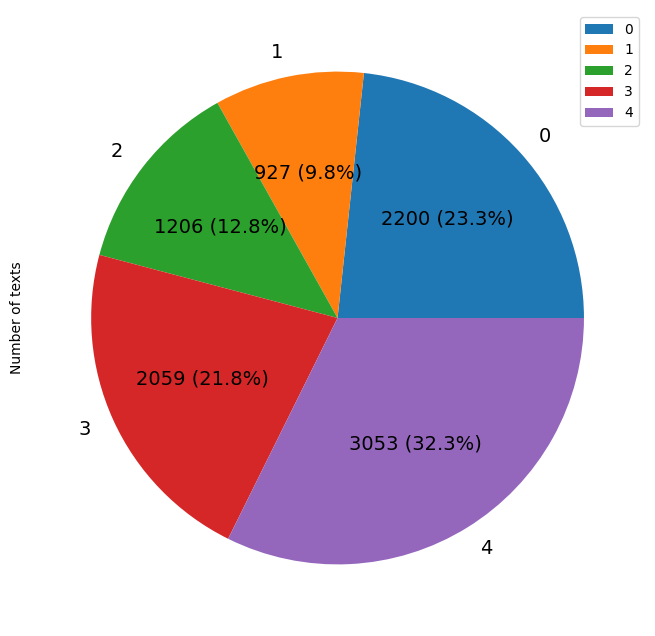

In [ ]:
get_dataset_statistics(train_data)

In [ ]:
test_data = raw_test_data[['text', 'label']].copy()

test_data['text'] = test_data['text'].apply(text_preprocessing)

test_data.drop_duplicates(inplace=True)

test_data

,text,label
0,obstructive sleep apnea following topical orop...,2
1,neutrophil function pyogenic infections bone m...,4
2,phase ii study combined methotrexate teniposid...,4
3,flow cytometric dna analysis parathyroid tumor...,0
4,paraneoplastic vasculitic neuropathy treatable...,3
...,...,...
2883,management aortobronchial fistula graft replac...,3
2884,tuberculous psoas muscle abscess following che...,4
2885,clinical evaluation highfrequency ultrasonic m...,3
2886,antitumor activity liposomeencapsulated doxoru...,0


# Text Representation

In [ ]:
word2vec_model = api.load("word2vec-google-news-300")

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [ ]:
def get_text_vec(sent):
  vector = np.mean(np.array([word2vec_model[token] for token in word_tokenize(sent) if token in word2vec_model.key_to_index]), axis=0)
  if np.all(np.isnan(vector)) :
    return np.zeros(300)
  return vector

In [ ]:
X_test = np.stack(np.array([get_text_vec(sms_text) for sms_text in test_data['text'].values]))

In [ ]:
X_test.shape

(2770, 300)

In [ ]:
y_test = test_data['label'].values

In [ ]:
y_test.shape

(2770,)

# Model selection, training and evaluation

In [ ]:
def f_beta_score(y_true, y_pred):
  return fbeta_score(y_true, y_pred, beta=2, average='macro')

f2_score = make_scorer(f_beta_score, greater_is_better=True)

In [ ]:
from datetime import datetime

def save_cross_validation(results, file_name):
  results_to_save = pd.DataFrame(columns=['Accuracy', 'Recall', 'Precision', 'F1 Score', 'F2 Score'])
  for i in range(0, 10):
    results_to_save.loc[i] = [
      results['split{}_test_Accuracy'.format(i)][0],
      results['split{}_test_Recall'.format(i)][0],
      results['split{}_test_Precision'.format(i)][0],
      results['split{}_test_F1'.format(i)][0],
      results['split{}_test_F2'.format(i)][0]
    ]
  results_to_save.to_csv('{}Results/{}_{}.csv'.format(dir_name+'experiments/Medical Text/', file_name, datetime.now().strftime("%m%d%H%M")))

In [ ]:
def train_model(classifier, param_grid, model_name, train_texts, train_labels, test_texts, test_labels, evaluation_metrics, to_print=True, to_save=False, file_name=None):
    """
    train email classification model.
    """

    # apply grid search to find best model hyper parameters
    grid_search = GridSearchCV(classifier, param_grid, cv=10, scoring={'Accuracy': make_scorer(accuracy_score),
                                                                       'F1': make_scorer(f1_score, average='macro'),
                                                                       'F2': f2_score,
                                                                       'Recall': make_scorer(recall_score, average='macro'),
                                                                       'Precision': make_scorer(precision_score, average='macro')
                                                                       }, refit='F1', n_jobs=-1)
    grid_search.fit(train_texts, train_labels)
    model = grid_search.best_estimator_

    if to_save:
      ConfusionMatrixDisplay(save_cross_validation(grid_search.cv_results_, file_name))
      plt.show()

    # train and test accuracy.
    test_accuracy = model.score(test_texts, test_labels)
    train_accuracy = model.score(train_texts, train_labels)

    # compute F1 score for model evaluation.
    y_pred = model.predict(test_texts)

    recall = recall_score(test_labels, y_pred, average='macro')
    precision = precision_score(test_labels, y_pred, average='macro')
    f1score = f1_score(test_labels, y_pred, average='macro')
    f2score = fbeta_score(y_test, y_pred, beta=2, average='macro')

    if to_print:
        print("train accuracy = " + str(train_accuracy))
        print("test accuracy = " + str(test_accuracy))
        print("Recall = {}".format(recall))
        print("Precision = {}".format(precision))
        print("F1 score = {}".format(f1score))
        print("F2 score = {}".format(f2score))
        print(classification_report(test_labels, y_pred))


        # plot confusion matrix
        cm = confusion_matrix(test_labels, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1,2,3,4])

        disp.plot(cmap=plt.cm.Blues)
        plt.show()

        # print best model hyper parameters.
        print(grid_search.best_params_)

    evaluation_metrics.loc[model_name, 'Recall'] = recall
    evaluation_metrics.loc[model_name, 'Precision'] = precision
    evaluation_metrics.loc[model_name, 'F1 score'] = f1score
    evaluation_metrics.loc[model_name, 'F2 score'] = f2score

    return f1score, f2score


def train(model_id, train_texts, train_labels, test_texts, test_labels, evaluation_metrics, to_print=True, to_save=False, file_name=None):
    
    if model_id == 1:
        # Random forest Classification model.
        forest_clf = RandomForestClassifier(random_state=42, n_jobs=-1)
        forest_param_grid = [{'n_estimators': [25, 30], 'max_features': [10, 15], 'min_samples_split': [15, 20, 25], 'criterion': ['gini','entropy'], 'max_depth': [5,6]}]

        return train_model(forest_clf, forest_param_grid, 'RandomForest', train_texts, train_labels, test_texts, test_labels, evaluation_metrics, to_print, to_save, file_name)

    if model_id == 2:
        # Support Vector Machine Model.
        svc_clf = SVC(random_state=42)
        svc_param_grid = [{'kernel': ['rbf'], 'degree': [2, 3 ,4, 5]}]

        return train_model(svc_clf, svc_param_grid, 'SVM', train_texts, train_labels, test_texts, test_labels, evaluation_metrics, to_print, to_save, file_name)

#Text Aug.

In [ ]:
from nltk.corpus import wordnet

def get_synonyms(word):
  synonyms = []
  for synonym in wordnet.synsets(word):
    for lemma in [l.name().lower() for l in synonym.lemmas()]:
      if len(lemma.split('_')) == 1 and lemma != word:
        synonyms.append(lemma)

  return list(set(synonyms))

In [ ]:
import itertools

def get_sentence_augmentations(sentence, similarity_threshold=.75):
  sentence_tokens = word_tokenize(sentence.lower())
  new_sentences = []
  words = []
  all_synonyms = []
  for word in sentence_tokens:
    if word in word2vec_model.key_to_index :
      synonyms = get_synonyms(word)
      if len(synonyms) > 0:
        good_synonyms = []
        for synonym in synonyms:
          if synonym in word2vec_model.key_to_index :
            if word2vec_model.similarity(word, synonym) >= similarity_threshold:
              good_synonyms.append(synonym)
        if len(good_synonyms) > 0:
          words.append(word)
          good_synonyms.append(word)
          all_synonyms.append(good_synonyms)
  for product in itertools.product(*all_synonyms):
    new_sentence = sentence
    for src, dest in zip(words, product):
        new_sentence = new_sentence.replace("%s" % src, dest)
    new_sentences.append(new_sentence)
    # new_sentences.remove(sentence)
  return new_sentences

In [ ]:
def my_augmentation(prepro_dataset, lable, similarity_threshold=.75):
  messages = prepro_dataset.loc[prepro_dataset['label'] == lable]['text'].values
  new_messages = []
  for msg in messages:
    new_messages.extend(get_sentence_augmentations(msg, similarity_threshold))
  augmentations = prepro_dataset[['text', 'label']].copy().append(pd.DataFrame({'label':[lable] * len(new_messages), 'text':new_messages}), ignore_index = True)
  augmentations.drop_duplicates(inplace=True)
  return augmentations.sample(frac=1)

In [ ]:
# best threshols 
augmented_dataset = my_augmentation(train_data, 1, .84)

<ipython-input-21-5cefabd9d516>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmentations = prepro_dataset[['text', 'label']].copy().append(pd.DataFrame({'label':[lable] * len(new_messages), 'text':new_messages}), ignore_index = True)


In [ ]:
augmented_dataset = my_augmentation(augmented_dataset, 2, .85)

<ipython-input-21-5cefabd9d516>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmentations = prepro_dataset[['text', 'label']].copy().append(pd.DataFrame({'label':[lable] * len(new_messages), 'text':new_messages}), ignore_index = True)


In [ ]:
augmented_dataset

,text,label
1617,prognostic indicators invasive breast cancer t...,0
5116,musculoskeletal problems association cloacal e...,2
3803,clinical experience technetium99m teboroxime n...,3
3544,tension pneumothorax secondary gastropleural f...,4
5898,regulation fibrillar collagen types iii baseme...,3
...,...,...
107,molecular characterization inherited mediumcha...,4
5279,vitrectomy retinotomy aspiration biopsy choroi...,0
8255,outpatient orthognathic surgery criteria revie...,4
7723,outcome pregnancy patients systemic lupus eryt...,4


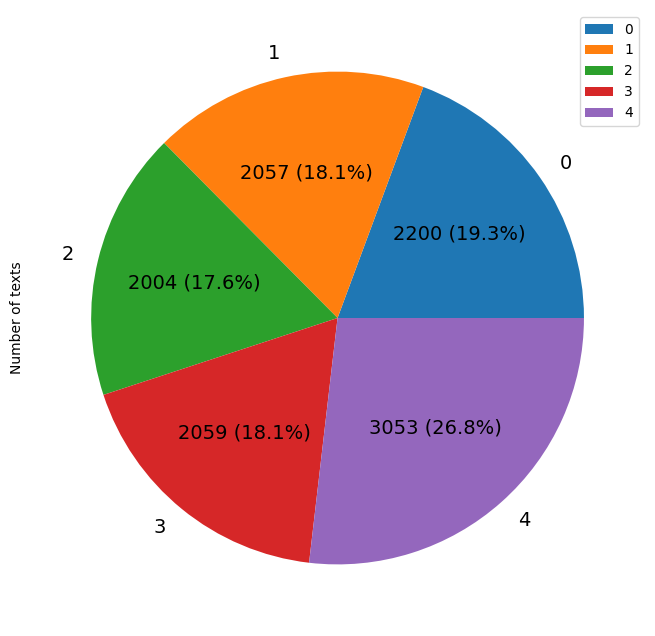

In [ ]:
get_dataset_statistics(augmented_dataset)

In [ ]:
aug_X_train = np.stack(np.array([get_text_vec(sms_text) for sms_text in augmented_dataset['text'].values]))

In [ ]:
aug_X_train.shape

(11373, 300)

In [ ]:
aug_y_train = augmented_dataset['label'].values

In [ ]:
aug_y_train.shape

(11373,)

In [ ]:
evaluation_metrics_aug = pd.DataFrame(columns = ['Recall', 'Precision', 'F1 score', 'F2 score'])

#RF
best threshold 1 -> .84, 2 -> .85

train accuracy = 0.6581376945396993
test accuracy = 0.5382671480144404
Recall = 0.5128645101540155
Precision = 0.5323543659427766
F1 score = 0.5197009594507624
F2 score = 0.5150278794108507
              precision    recall  f1-score   support

           0       0.67      0.73      0.70       616
           1       0.37      0.34      0.36       287
           2       0.54      0.39      0.45       366
           3       0.66      0.63      0.64       589
           4       0.43      0.47      0.45       912

    accuracy                           0.54      2770
   macro avg       0.53      0.51      0.52      2770
weighted avg       0.54      0.54      0.54      2770



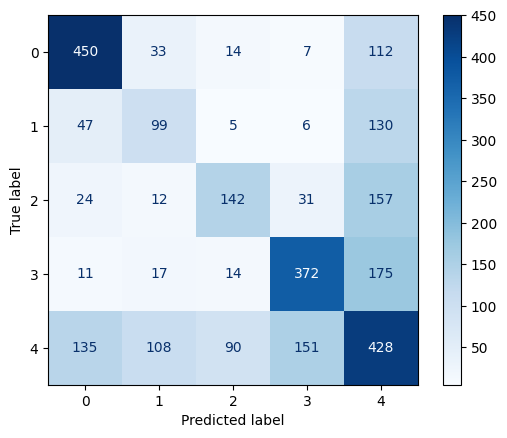

{'criterion': 'entropy', 'max_depth': 6, 'max_features': 15, 'min_samples_split': 20, 'n_estimators': 30}


(0.5197009594507624, 0.5150278794108507)

In [ ]:
train(1, aug_X_train, aug_y_train, X_test, y_test, evaluation_metrics_aug, to_save=True, file_name='TAMS_RF')

# SVM
best threshold 1 -> .84, 2 -> .85

train accuracy = 0.7332278202760925
test accuracy = 0.6032490974729242
Recall = 0.614704092051065
Precision = 0.5905031201376342
F1 score = 0.6001861308170567
F2 score = 0.6083074881336479
              precision    recall  f1-score   support

           0       0.71      0.77      0.74       616
           1       0.48      0.57      0.52       287
           2       0.57      0.55      0.56       366
           3       0.68      0.76      0.71       589
           4       0.52      0.42      0.47       912

    accuracy                           0.60      2770
   macro avg       0.59      0.61      0.60      2770
weighted avg       0.60      0.60      0.60      2770



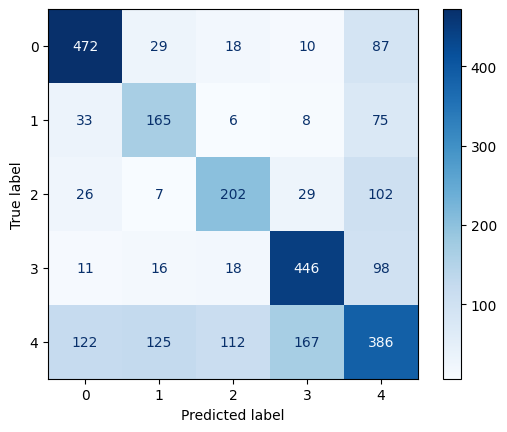

{'degree': 2, 'kernel': 'rbf'}


(0.6001861308170567, 0.6083074881336479)

In [ ]:
train(2, aug_X_train, aug_y_train, X_test, y_test, evaluation_metrics_aug,  to_save=True, file_name='TAMS_SVM')

In [ ]:
evaluation_metrics_aug

#BiLSTM


In [ ]:
import random
import tensorflow as tf 
from tensorflow import keras 
from tensorflow.keras import layers
from sklearn.metrics import ConfusionMatrixDisplay
from tensorflow.keras.layers import Dropout, SpatialDropout1D
from tensorflow.keras import regularizers
from sklearn.model_selection import StratifiedKFold

In [ ]:
def create_blstm_model(train_texts):

  vectorize_layer = layers.TextVectorization(max_tokens=2000, output_sequence_length=200)

  vectorize_layer.adapt(train_texts)

  embedding_layer = layers.Embedding(input_dim=2000, output_dim=32)

  model = tf.keras.models.Sequential()
  model.add(tf.keras.Input(shape=(1,), dtype=tf.string))
  model.add(vectorize_layer)
  model.add(embedding_layer)
  model.add(SpatialDropout1D(0.2))
  model.add(layers.Bidirectional(layers.LSTM(64, bias_regularizer=regularizers.L2(1e-4), kernel_regularizer=regularizers.L1L2(l1=1e-4, l2=1e-4), activity_regularizer=regularizers.L2(1e-4))))
  model.add(Dropout(0.2))
  model.add(layers.Dense(5, activation='softmax'))


  model.compile(optimizer=keras.optimizers.Adam(),
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])  
  print(model.summary())
  
  return model

# Cross Validation

In [ ]:
def cv_blstm():

  kf = StratifiedKFold(10, shuffle=True, random_state=42) 
  cv_metrics = pd.DataFrame(columns = ['Recall', 'Precision', 'F1 score', 'F2 score'])

  fold = 0

  X = augmented_dataset['text'].values
  Y = augmented_dataset['label'].values

  for train, val in kf.split(X, Y):  
  
    print(f"Fold {fold}")

    train_texts = X[train]
    train_labels = Y[train]
    test_texts = X[val]
    test_labels = Y[val]

    blstm_model = create_blstm_model(train_texts)

    history = blstm_model.fit(train_texts,
                              train_labels,
                              epochs=10,
                              batch_size=64,
                              validation_data=(test_texts, test_labels))

    blstm_model.evaluate(test_texts, test_labels)
    y_pred = np.round(blstm_model.predict(test_texts))
    y_pred = np.argmax(y_pred, axis=1)

    f1_sc = f1_score(test_labels, y_pred, average='macro')
    f2score = fbeta_score(test_labels, y_pred, beta=2, average='macro')

    cv_metrics.loc[fold, 'Recall'] = recall_score(test_labels, y_pred, average='macro')
    cv_metrics.loc[fold, 'Precision'] = precision_score(test_labels, y_pred, average='macro')
    cv_metrics.loc[fold, 'F1 score'] = f1_sc
    cv_metrics.loc[fold, 'F2 score'] = f2score
    
    fold += 1

  return cv_metrics

In [ ]:
cv_results = cv_blstm()

Fold 0
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 200)              0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 200, 32)           64000     
                                                                 
 spatial_dropout1d (SpatialD  (None, 200, 32)          0         
 ropout1D)                                                       
                                                                 
 bidirectional (Bidirectiona  (None, 128)              49664     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                 

In [ ]:
cv_results

,Recall,Precision,F1 score,F2 score
0,0.70116,0.664661,0.666836,0.684278
1,0.711971,0.68838,0.691819,0.701952
2,0.705133,0.686003,0.687681,0.696152
3,0.703596,0.685501,0.684696,0.693546
4,0.731931,0.720376,0.721725,0.726687
5,0.720517,0.707078,0.708237,0.714162
6,0.711277,0.709007,0.703323,0.70625
7,0.65322,0.664227,0.64879,0.648826
8,0.704037,0.685693,0.684762,0.69388
9,0.718309,0.712588,0.704466,0.709867


In [ ]:
cv_results.mean()

Recall       0.706115
Precision    0.692351
F1 score     0.690233
F2 score     0.697560
dtype: float64

In [ ]:
def train_blstm(train_texts, train_labels, test_texts, test_labels):

  blstm_model = create_blstm_model(train_texts)
  
  history = blstm_model.fit(train_texts,
                            train_labels,
                            epochs=10,
                            batch_size=64,
                            validation_data=(test_texts, test_labels))
  
  blstm_model.evaluate(test_texts, test_labels)
  y_pred = np.round(blstm_model.predict(test_texts))

  y_pred = np.argmax(y_pred, axis=1)

  f1_sc = f1_score(test_labels, y_pred, average='macro')
  f2score = fbeta_score(test_labels, y_pred, beta=2, average='macro')

  print("Recall = {}".format(recall_score(test_labels, y_pred, average='macro')))
  print("Precision = {}".format(precision_score(test_labels, y_pred, average='macro')))
  print("F1 score = {}".format(f1_sc))
  print("F2 score = {}".format(f2score))
  print(classification_report(test_labels, y_pred))
  
  cm = confusion_matrix(test_labels, y_pred)

  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1,2,3,4])

  disp.plot(cmap=plt.cm.Blues)
  plt.show()

  return f1_sc

In [ ]:
X_test = test_data['text'].values.reshape(-1, 1)

In [ ]:
X_test.shape

(2770, 1)

In [ ]:
y_test = test_data['label'].values

In [ ]:
aug_X_train = augmented_dataset['text'].values.reshape(-1, 1)

In [ ]:
aug_X_train.shape

(11373, 1)

In [ ]:
aug_y_train = augmented_dataset['label'].values.reshape(-1, 1)

In [ ]:
aug_y_train.shape

(11373, 1)

In [ ]:
unique, counts = np.unique(aug_y_train, return_counts=True)
dict(zip(unique, counts))

{0: 2200, 1: 2057, 2: 2004, 3: 2059, 4: 3053}

Model: "sequential_41"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_41 (Text  (None, 200)              0         
 Vectorization)                                                  
                                                                 
 embedding_41 (Embedding)    (None, 200, 32)           64000     
                                                                 
 spatial_dropout1d_20 (Spati  (None, 200, 32)          0         
 alDropout1D)                                                    
                                                                 
 bidirectional_40 (Bidirecti  (None, 128)              49664     
 onal)                                                           
                                                                 
 dropout_38 (Dropout)        (None, 128)               0         
                                                     

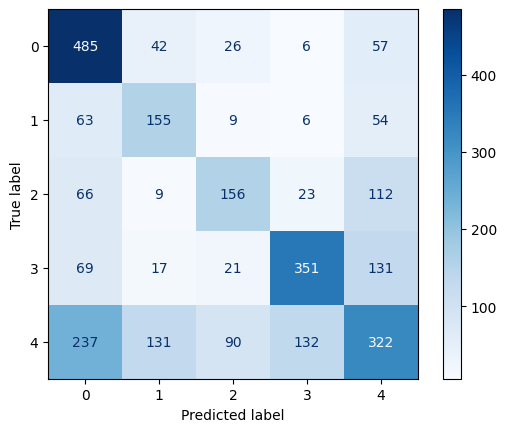

0.5243767065760383

In [ ]:
train_blstm(aug_X_train, aug_y_train, X_test, y_test)